In [20]:
# 1.Import required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from scipy import stats
import re
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
import lightgbm as lgb
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score, 
                             balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score)

In [21]:
# 2.Define Classes and Functions
# Create class for preprocessing, which will include steps like reformatting, ensuring correct data-types, etc.
class preprocessDatasets:
  def join_ID(self, transaction_df: pd.DataFrame, ID_df: pd.DataFrame):  
    ''' 
    Function to join datasets based on transaction ID.

    Parameters:
    -transaction_df (pd.Dataframe): transaction dataset
    -ID_df (pd.Dataframe): identity dataset

    Returns:
    -merged_df (pd.Dataframe): merged transaction & identity dataset
    '''

    merged_df = pd.merge(transaction_df, ID_df, on='TransactionID', how='outer')
    col_list = []
    for col in merged_df.columns:
      if '-' in col:  # Replace '-' and '_' since column names between the two datasets does not align
        col = col.replace('-', '_')
      col_list.append(col)
    merged_df.columns = col_list
    return merged_df

  def replace_blanks(self, df: pd.DataFrame):
    ''' 
    Function to replace blanks with "holder" value of -999.

    Parameters:
    -df (pd.Dataframe): dataset

    Returns:
    -df (pd.Dataframe): dataset with no blank values
    '''

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):  # Check if the column is numeric
            df[col].fillna(-999, inplace=True)

        else:
            df[col].fillna('-999', inplace=True)

    return df
  
  def encode_df(self, df: pd.DataFrame):
    ''' 
    Encode/scale dataframe columns to maintain data quality prior to feeding into model.

    Parameters:
    -df (pd.Dataframe): dataset to be encoded/scaled

    Returns:
    -df (pd.Dataframe): encoded & scaled dataset
    '''

    # Create instances of the transformers
    label_encoder = LabelEncoder()
    scaler = StandardScaler()
    minmax_scaler = MinMaxScaler()

    # Loop through each column and determine its type, then encode/scale accordingly
    for col in df.columns:
      if col == 'TransactionID' or col == 'isFraud':  # These two columns can be left as is, and will be needed for processing later
          continue
      
      # MinMax Scale D-columns as indicated from the plots and correlation matrix
      elif re.match(r'^D\d+$', col):
          df[col] = minmax_scaler.fit_transform(df[[col]])

      # Check if the column is numeric
      elif pd.api.types.is_numeric_dtype(df[col]):
          df[col] = scaler.fit_transform(df[[col]])

      # Process non-numeric columns (object types)
      else:
          df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

    return df
  
  def remove_outliers(self, data: pd.DataFrame, column: str):
    '''
    Remove outliers in transaction amount col that are >3sigma based on a single column, in this case transaction amount.

    Parameters:
    -df (pd.Dataframe): dataset to be encoded/scaled
    -column (str): reference column to remove outliers

    Returns:
    -data (pd.Dataframe): dataset with rows contained outliers removed
    '''
    
    z_scores = stats.zscore(data[column])  # z-score each of the columns
    non_outliers = np.abs(z_scores) < 3
    original_len = len(data)  # calculate to initial length to note count of values removed
    data = data[non_outliers]
    final_len = len(data)  # calculate to final length to note count of values removed
    print(f'{original_len - final_len} values were removed, since they contianed outliers (z-score over 3)')
    return data
  
  def remove_empty_cols(self, data: pd.DataFrame):
    '''
    Drop col if more than 90% of the col is missing (NaN).

    Parameters:
    -data (pd.Dataframe): dataset to be processed

    Returns:
    -data (pd.Dataframe): dataset where columns exceeding the blank-threshold are dropped
    '''

    threshold = 0.90
    data.dropna(thresh=int((1 - threshold) * len(data)), axis=1, inplace=True)
    return data
  
  def feature_engineer(self, data: pd.DataFrame):
    '''
    Feature engineer dataset to extract more details from certain columns.

    Parameters:
    -data (pd.Dataframe): dataset to be processed

    Returns:
    -df (pd.Dataframe): dataset where columns exceeding the blank-threshold are dropped
    '''

    # OS col contains multiple versions, which are minor and should be treated the same
    # id_33 includes screen size, split for width and height
    # id_31 has browser info
    # DeviceInfo contains type of device, etc.
    data[['P_emailserver', 'P_suffix']] = data['P_emaildomain'].str.split('.', n=1, expand=True)
    data[['R_emailserver', 'R_suffix']] = data['R_emaildomain'].str.split('.', n=1, expand=True)
    data['os'] = data['id_30'].str.split(' ', expand=True)[0]
    data['screen_width'] = data['id_33'].str.split('x', expand=True)[0]
    data['screen_height'] = data['id_33'].str.split('x', expand=True)[1]
    data['screen_width'] = pd.to_numeric(data['screen_width'])
    data['screen_height'] = pd.to_numeric(data['screen_height'])

    # Modify browser identification
    data['browser'] = data['id_31'].str.split(' ', expand=True)[0].str.lower()
    data['device_name'] = data['DeviceInfo'].str.split(' ', expand=True)[0].str.lower()

    def matchPatterns(df: pd.DataFrame, patterns, col_name: str):
      for pattern, value in patterns.items():
        # Apply regex pattern to match and replace values in the column
        df[col_name] = df[col_name].str.replace(pattern, value, regex=True)
      return df

    browser_patterns = {
      r'samsung/sm-g532m|samsung/sch|samsung/sm-g531h': 'samsung',
      r'generic/android': 'android',
      r'mozilla/firefox': 'firefox',
      r'nokia/lumia': 'nokia',
      r'zte/blade': 'zte',
      r'lg/k-200': 'lg',
      r'lanix/ilium': 'lanix',
      r'blu/dash': 'blu',
      r'm4tel/m4': 'm4'
    }

    device_patterns = {
      r'samsung|sgh|sm|gt-': 'samsung',
      r'mot': 'motorola',
      r'ale-|.*-l|hi': 'huawei',
      r'lg': 'lg',
      r'rv:': 'rv',
      r'blade': 'zte',
      r'xt': 'sony',
      r'iphone': 'ios',
      r'lenovo': 'lenovo',
      r'mi|redmi': 'xiaomi',
      r'ilium': 'ilium',
      r'alcatel': 'alcatel',
      r'asus': 'asus'
    }

    data = matchPatterns(data, browser_patterns, 'browser')
    data = matchPatterns(data, device_patterns, 'device_name')

    # Modify date format to split day, month, etc.
    start_date = datetime(2017, 11, 30)
    data['TransactionFullDate'] = data['TransactionDT'].apply(lambda x: start_date + timedelta(seconds=x))
    data['TransactionDate'] = data['TransactionFullDate'].dt.date
    data['DayOfWeek'] = data['TransactionFullDate'].dt.dayofweek.apply(lambda x: (x + 1) % 7)    # Sunday=0, Monday=1, Tuesday=2, etc
    data['HourOfDay'] = data['TransactionFullDate'].dt.hour   # from 0 to 23
    data['Month'] = data['TransactionFullDate'].dt.month
    return data
  
  def reduce_memory(self, df: pd.DataFrame):
    '''
    Reduce memory by analyzing max/min value in cols and minimizing column data type

    Parameters:
    -df (pd.Dataframe): dataset used for memory reduction

    Returns:
    -df (pd.Dataframe): dataset with reduced memory
    '''

    start = df.memory_usage().sum() / 1024**2  # Get initial memory
    print('Starting memory usage of the dataframe: {:.2f} MB'.format(start))
    
    for col in df.columns:  # Apply memory reduction steps
        col_type = df[col].dtype
        
        if str(col_type).startswith('float'):
            col_min = df[col].min()
            col_max = df[col].max()
            if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)

        elif str(col_type).startswith('int'):
            col_min = df[col].min()
            col_max = df[col].max()
            if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)

        else:
            df[col] = df[col].astype('category')
    
    end = df.memory_usage().sum() / 1024**2  # Get final memory
    print('Memory usage after downsizing: {:.2f} MB'.format(end))
    print('Memory usage decreased by {:.1f}%'.format(100 * (start - end) / start))
    return df

  def final_preprocessing(self, train_df: pd.DataFrame, test_df: pd.DataFrame):
    '''
    Apply final preprocessing steps such as dropping cols, sorting, reformatting, etc.
    
    Parameters:
    -train_df (pd.Dataframe): training dataset to be used by the model
    -test_df (pd.Dataframe): testing dataset to be used by the model

    Returns:
    -train_df (pd.Dataframe): fully processed training dataset
    -dropped_df (pd.Dataframe): fully processed testing dataset
    '''

    # Sort values to keep predictions in submission format
    train_df = train_df.sort_values(by='TransactionID', ascending=True).reset_index(drop=True)
    test_df = test_df.sort_values(by='TransactionID', ascending=True).reset_index(drop=True)

    # Drop unnecessary columns
    train_df.drop(columns=['P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33', 'DeviceInfo', 'TransactionDT', 'TransactionFullDate', 'TransactionDate', 'TransactionID'], inplace=True)
    test_df.drop(columns=['P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33', 'DeviceInfo', 'TransactionDT', 'TransactionFullDate', 'TransactionDate', 'TransactionID'], inplace=True)

    # Due to removal of cols with >90% missing values, the column removals need to be carried over to test dataset as well
    col_drop =[]
    for col in test_df.columns:
       if col not in train_df.columns:
          col_drop.append(col)
    
    dropped_df = test_df.drop(columns=col_drop)
    return train_df, dropped_df

In [22]:
class visualizeDataset:
  def plot_hist(self, df: pd.DataFrame, col: str, plot_fraud: bool):
    '''
    Plot histogram of transactions for fraud/non-fraud etc.
    
    Parameters:
    -df (pd.Dataframe): training dataset to be visualized
    -col (str): column to use for plotting histogram
    -plot_fraud (bool): boolean to choose whether fraud and non-fraud transaction should be plotted separately

    Displays: Plots as needed
    '''

    if plot_fraud:
      # Fraudulent transactions
      data_fraud = df.loc[df['isFraud'] == 1]
      data_fraud_col = data_fraud[col]

      # Non-fraudulent transactions
      data_nofraud = df.loc[df['isFraud'] == 0]
      data_nofraud_col = data_nofraud[col]

      # Create two subplots
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

      # Plot fraudulent histogram in the first subplot
      ax1.hist(data_fraud_col, bins=100, color='red', edgecolor='black')
      ax1.set_xlabel('Value ($)')
      ax1.set_ylabel('Freq.')
      ax1.set_title(f'Fraudulent Transactions')

      # Plot non-fraudulent histogram in the second subplot
      ax2.hist(data_nofraud_col, bins=100, color='blue', edgecolor='black')
      ax2.set_xlabel('Value ($)')
      ax2.set_ylabel('Freq.')
      ax2.set_title(f'Non-Fraudulent Transactions')

      # Show the plots
      plt.tight_layout()  # Adjust layout for better spacing
      plt.show()
    else:
      data = df[col]
      plt.hist(data, bins=100, edgecolor='black')
      plt.xlabel('Value ($)')
      plt.ylabel('Freq.')
      plt.title(f'Histogram of {col} for all Transactions')
      plt.show()
    
  def plot_fraud_per_period(self, df: pd.DataFrame, period_cols: list):
    '''
    Plot fraud transactions per unit of time (day, month, hour, etc.)
    
    Parameters:
    -df (pd.Dataframe): training dataset to be visualized
    -period_cols (list): columns to use for plotting

    Displays: Plots as needed
    '''

    # Create a figure with subplots for each column
    fig, axes = plt.subplots(len(period_cols), 1, figsize=(6, 4 * len(period_cols)))
    for idx, col in enumerate(period_cols):
        # Get fraud data
        fraud_df = df.loc[df['isFraud'] == 1]

        # Group by the specified column and count occurrences
        fraud_grouped = fraud_df.groupby(col)['isFraud'].size()

        # Calculate total transactions per category
        total_grouped = df.groupby(col)['isFraud'].size()

        # Calculate percentages for fraud
        fraud_percentage = (fraud_grouped / total_grouped * 100).fillna(0)

        # Get the index values (categories) from fraud_percentage
        categories = fraud_percentage.index

        # Plot the fraud percentages in red on the current subplot (axes[idx])
        axes[idx].bar(categories, fraud_percentage, color='red', edgecolor='black')

        # Add labels and title
        axes[idx].set_xlabel(col)  # Label for the x-axis
        axes[idx].set_ylabel('Fraud Percentage (%)')
        axes[idx].set_title(f'Fraud Percentage by {col}')
    plt.show()
  
  def plot_correlation(self, df: pd.DataFrame, cols: list):
    '''
    Plot correlation matrices as needed
    
    Parameters:
    -df (pd.Dataframe): training dataset to be visualized
    -cols (list): columns to use for plotting correlation matrix

    Displays: Plots as needed
    '''

    subset = df[cols]
    corr_matrix = subset.corr()
    plt.figure(figsize=(13, 13))  
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, square=True)
    plt.title('Correlation Heatmap of Selected Columns')
    plt.show()


In [23]:
class ReduceDeminesion():  # Due to size of dataset, apply dimensionality reduction steps
  def __init__(self, traindata: pd.DataFrame, testdata: pd.DataFrame):
    '''
    Initialize class
    
    Parameters:
    -traindata (pd.Dataframe): training dataset
    -testdata (pd.Dataframe): testing dataset
    '''

    self.traindata = traindata
    self.testdata = testdata
    self.v_cols = []
    
  def plot_and_reduceD(self, plots=True):
    '''
    Plot scree plot and apply Principal-Component-Analysis to ensure important correlations are extracted
    
    Parameters:
    -plots (bool): Whether of not to show plots (scree plot)

    Displays: Plots as needed

    Retruns:
    -data_final (pd.Dataframe): training dataset with reduced dimensions
    -test_data_final (pd.Dataframe): testing dataset with reduced dimensions
    '''

    v_cols = [col for col in self.traindata.columns if re.match(r'^V\d+$', col)]
    
    # PCA on training data
    v_data = self.traindata[v_cols]
    pca = PCA().fit(v_data)  # Fit PCA on training data
    v_data_pca = pca.transform(v_data)  # Transform training data
    explained_variance = pca.explained_variance_ratio_.cumsum()

    # Apply PCA to test data using the same PCA model
    v_test_data = self.testdata[v_cols]
    v_test_data_pca = pca.transform(v_test_data)  # Transform test data using fitted PCA model

    # Number of components to retain based on Kaiser criterion
    num_components_kaiser = sum(eigenvalue > 1 for eigenvalue in pca.explained_variance_)
    print(f"Number of components to retain (Kaiser criterion): {num_components_kaiser}")

    if plots:
      # Scree plot
      plt.figure(figsize=(10, 6))
      plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
      plt.xlabel('Principal Component')
      plt.ylabel('Explained Variance Ratio')
      plt.title('Scree Plot')
      plt.grid()

      # Zoomed-in scree plot (x-axis up to 30)
      plt.figure(figsize=(10, 6))
      plt.plot(range(1, 31), pca.explained_variance_ratio_[:30], marker='o', linestyle='--')
      plt.xlabel('Principal Component')
      plt.ylabel('Explained Variance Ratio')
      plt.title('Zoomed-in Scree Plot (First 30 Components)')
      plt.grid()

      # Cumulative explained variance plot
      plt.figure(figsize=(10, 6))
      plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
      plt.xlabel('Number of Principal Components')
      plt.ylabel('Cumulative Explained Variance')
      plt.title('Cumulative Explained Variance vs. Number of Principal Components')
      plt.axhline(y=0.90, color='r', linestyle='-')
      plt.text(12, 0.87, '90% mark', color='red', fontsize=10)
      plt.grid()
      plt.show()

    # Determine the number of components to retain for 90% variance
    comp_90 = next(i for i, total in enumerate(explained_variance) if total >= 0.90) + 1
    print(f"\nNumber of components to retain for 90% variance: {comp_90}")
    print(f"Cumulative Explained Variance for the {comp_90}th component: {explained_variance[comp_90-1]:.4f}\n")

    # Transform training data into the reduced-dimensional PCA space
    v_data_pca_df = pd.DataFrame(v_data_pca[:, :comp_90], columns=[f'PC{i+1}' for i in range(comp_90)])
    data_final = pd.concat([self.traindata.drop(columns=v_cols).reset_index(drop=True), v_data_pca_df], axis=1)

    # Transform test data into the same reduced-dimensional PCA space
    v_test_data_pca_df = pd.DataFrame(v_test_data_pca[:, :comp_90], columns=[f'PC{i+1}' for i in range(comp_90)])
    test_data_final = pd.concat([self.testdata.drop(columns=v_cols).reset_index(drop=True), v_test_data_pca_df], axis=1)

    # Return both the transformed training and test datasets
    return data_final, test_data_final

In [24]:
class applyModel():
  def __init__(self, eval=True):
    """
    Initialize class

    Parameters:
    -y_test: if model evaluation should be shown
    """

    self.eval = eval

  def evaluateModel(self, y_test, y_pred, y_pred_proba):
    """
    evaluate the model using various metrics and print the results

    Parameters:
    -y_test: testing labels
    -y_pred: predicted labels
    -y_pred_proba: predicted probabilities for the positive class
    """
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Basic Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Additional Metrics
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    # Classification Report
    class_report = classification_report(y_test, y_pred)

    # Print Metrics
    print('\n\n -------------Model Evaluation Metrics-------------')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')
    print(f'Balanced Accuracy: {balanced_acc:.4f}')
    print(f'Matthew\'s Correlation Coefficient: {mcc:.4f}')
    print(f'Cohen\'s Kappa: {kappa:.4f}')
    print('\nClassification Report:')
    print(class_report)

    metrics = [accuracy, precision, recall, f1, roc_auc, balanced_acc, mcc, kappa]

    return metrics

  def trainModel(self, X_train_split: pd.DataFrame, X_val_split: pd.DataFrame, y_train_split: pd.DataFrame, y_val_split: pd.DataFrame):
    """
    Train model on dataset, and use validation datasets as reference for training to apply early stopping during training intervals

    Parameters:
    -X_train_split (pd.DataFrame): X features of the training dataset
    -X_val_split (pd.DataFrame): X features of the validation dataset
    -y_train_split (pd.DataFrame): y features of the trainig dataset
    -y_val_split (pd.DataFrame): y features of the validation dataset

    Displays: XGB model evaluation if eval was marked as true when class was called

    Returns:
    -xgb_model (xgb.XGBClassifier): XGB trained model
    """

    # Weigh classes differently since majority are "safe" transactions leading to class imbalance
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    # Define the XGBoost model
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',        # Binary classification
        eval_metric='auc',                  # Log loss metric for binary classification
        use_label_encoder=False,            # Disable the label encoder warning
        learning_rate=0.05,                  # Learning rate, same as your NN learning rate
        n_estimators=5000,                  # Number of boosting rounds (trees)
        max_depth=6,                        # Maximum depth of trees
        subsample=0.8,                      # Subsample ratio of the training instances
        colsample_bytree=0.8,               # Subsample ratio of columns
        scale_pos_weight=scale_pos_weight   # Use scale_pos_weight for imbalanced datasets if needed
    )

    # Train the XGBoost model
    xgb_model.fit(
        X_train_split, 
        y_train_split, 
        eval_set=[(X_val_split, y_val_split)],  # Validation data to monitor overfitting
        early_stopping_rounds=10,               # Stop early if no improvement
        verbose=False                           # Print progress (Toggle true/false)
    )

    # Predict probabilities of fraud for the val/test set
    yval_pred = xgb_model.predict(X_val_split)
    yval_pred_proba = xgb_model.predict_proba(X_val_split)[:, 1]  # Get probabilities for the positive class (fraud)

    if self.eval:
      metrics = applyModel.evaluateModel(self, y_val_split, yval_pred, yval_pred_proba)

    return xgb_model
  
  def pred_and_submit(self, model: xgb.XGBClassifier, Xtest: pd.DataFrame, plot_pred=True):
    """
    Apply the model to predict based on the testing dataset and format predictions for submission

    Parameters:
    -model (xgb.XGBClassifier): XGB trained model
    -Xtest (pd.DataFrame): X features of the test dataset
    -plot_pred (bool): whether to plot predictions historgram

    Displays: predictions histogram if plot_pred=True

    Returns:
    -submission (pd.DataFrame): predictions from model in submission format as a dataframe
    """

    # Predict probabilities of fraud for the test set
    y_pred_proba = model.predict_proba(Xtest)[:, 1]  # Get probabilities for the positive class (fraud)

    # Create the submission DataFrame
    submission = pd.DataFrame({
      'TransactionID': test_transaction_df['TransactionID'],
      'isFraud': y_pred_proba
    })

    if plot_pred:
      # Plot a histogram of the model predictions if needed
      plt.figure(figsize=(8, 6))
      plt.hist(submission['isFraud'], bins=100, edgecolor='black')
      plt.title('Histogram of Fraud Probabaility')
      plt.xlabel('Fraud Probability')
      plt.ylabel('Frequency')
      plt.grid(True)
      plt.show()

    # Save the submission DataFrame to CSV if needed
    submission.to_csv('submission.csv', index=False)

    return submission

10093 values were removed, since they contianed outliers (z-score over 3)


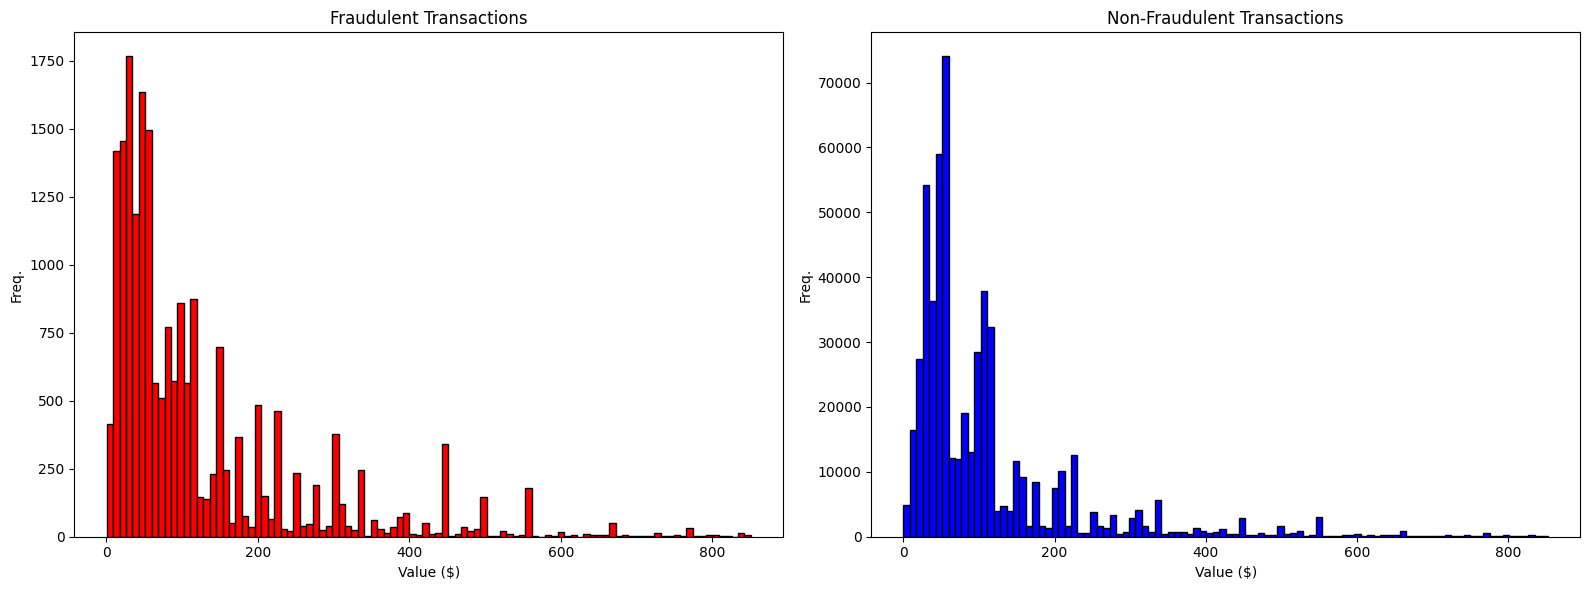

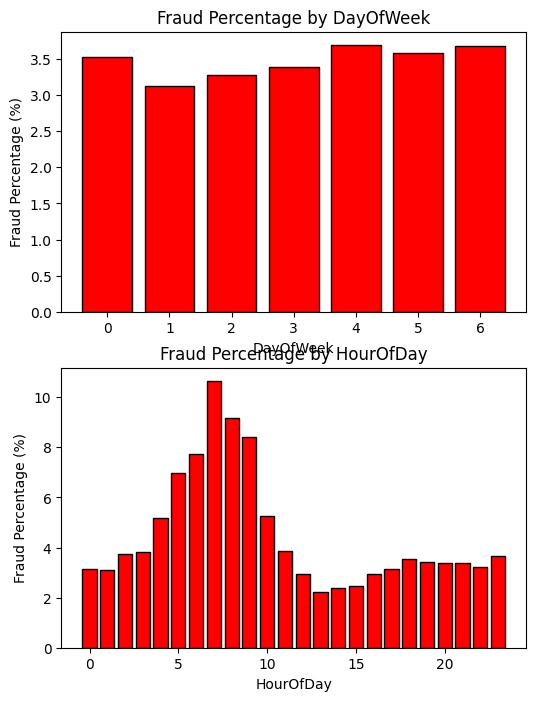

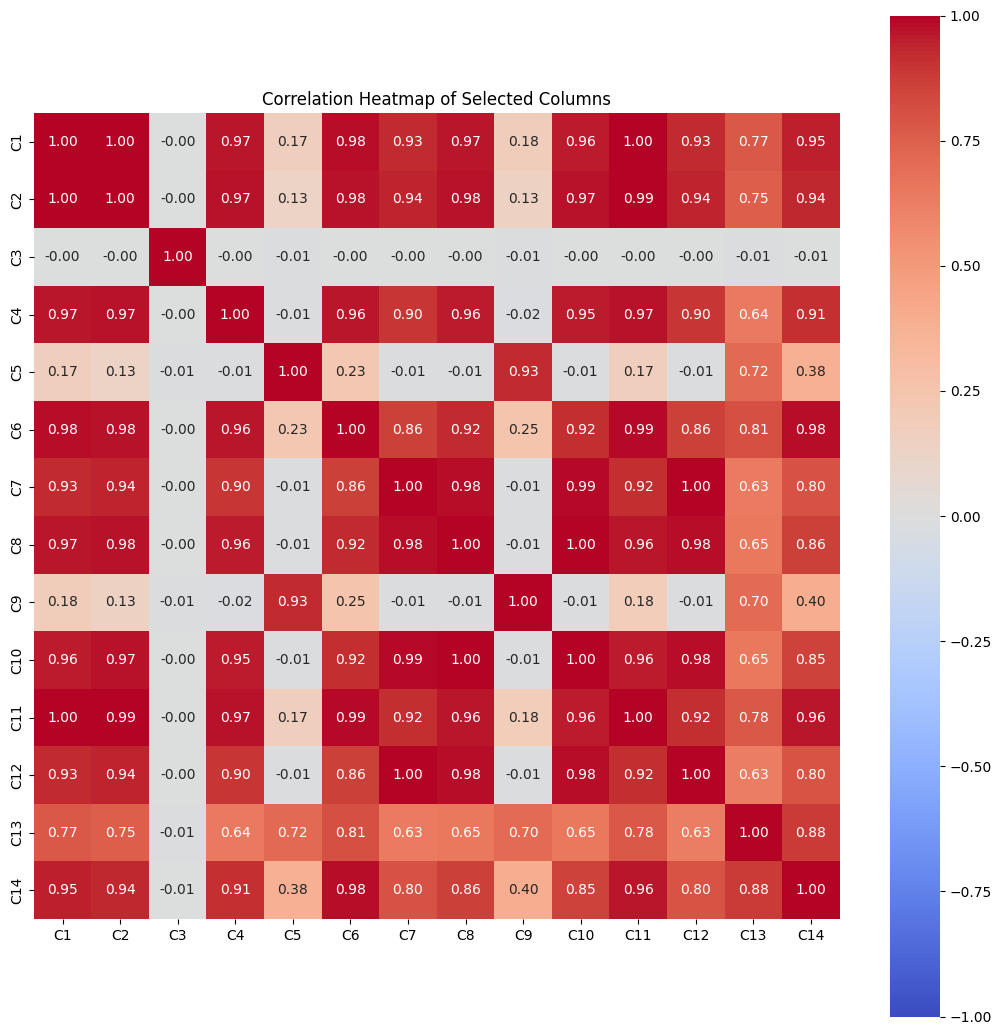

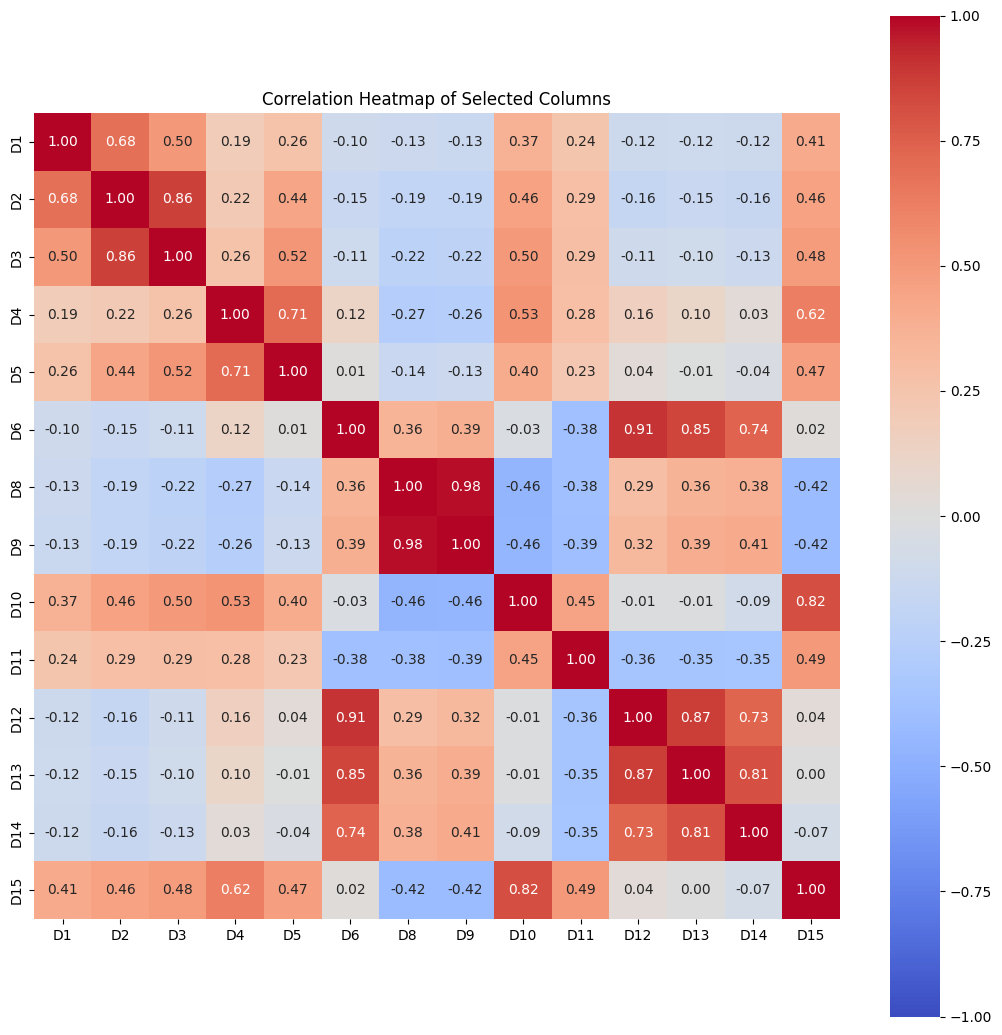

Starting memory usage of the dataframe: 1935.24 MB
Memory usage after downsizing: 926.20 MB
Memory usage decreased by 52.1%
Starting memory usage of the dataframe: 1685.47 MB
Memory usage after downsizing: 808.18 MB
Memory usage decreased by 52.0%
Number of components to retain (Kaiser criterion): 19


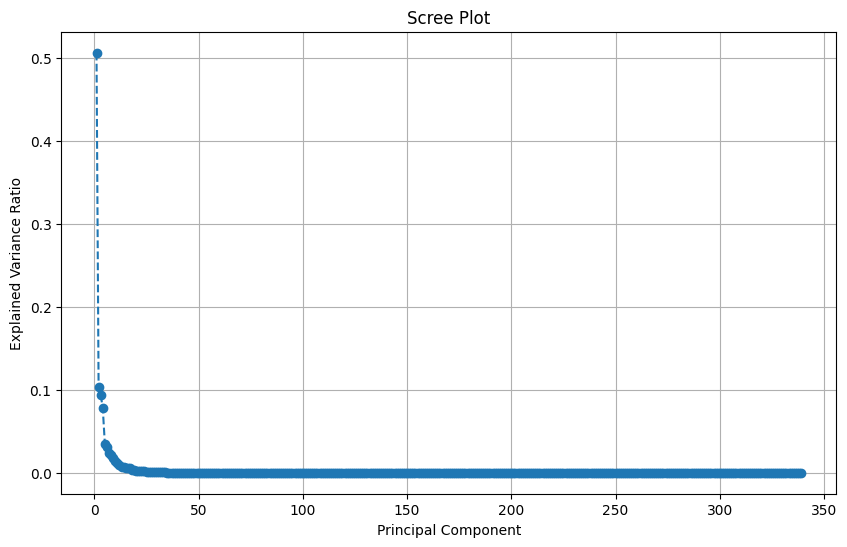

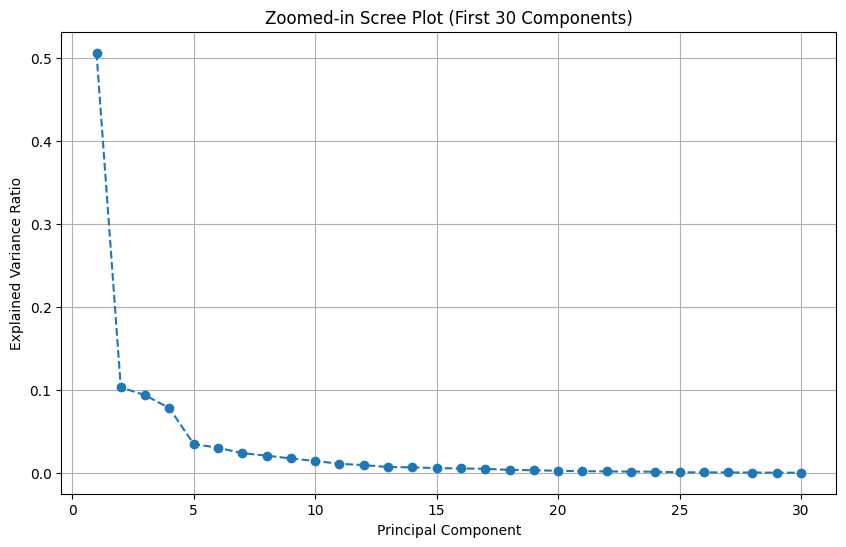

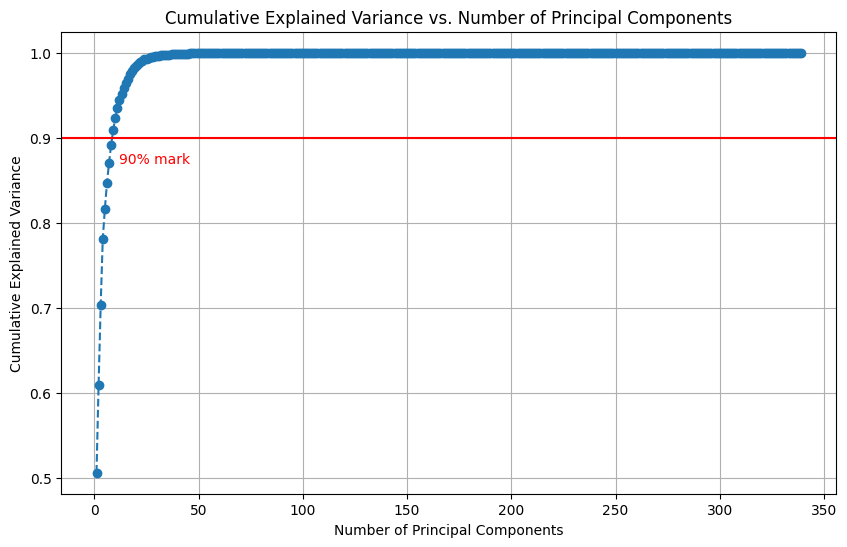


Number of components to retain for 90% variance: 9
Cumulative Explained Variance for the 9th component: 0.9088



C:\Users\athar\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


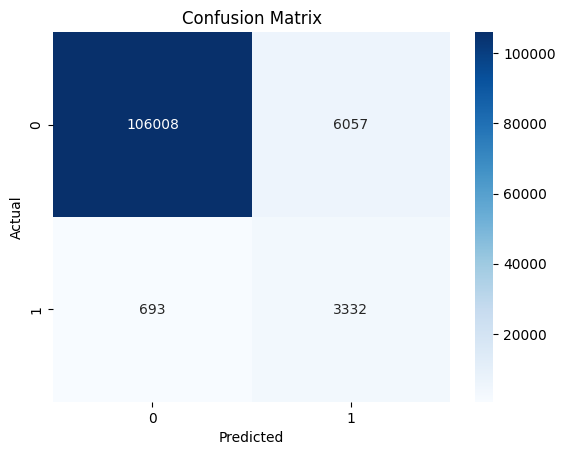



 -------------Model Evaluation Metrics-------------
Accuracy: 0.9419
Precision: 0.3549
Recall: 0.8278
F1 Score: 0.4968
ROC-AUC: 0.9572
Balanced Accuracy: 0.8869
Matthew's Correlation Coefficient: 0.5192
Cohen's Kappa: 0.4711

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    112065
           1       0.35      0.83      0.50      4025

    accuracy                           0.94    116090
   macro avg       0.67      0.89      0.73    116090
weighted avg       0.97      0.94      0.95    116090



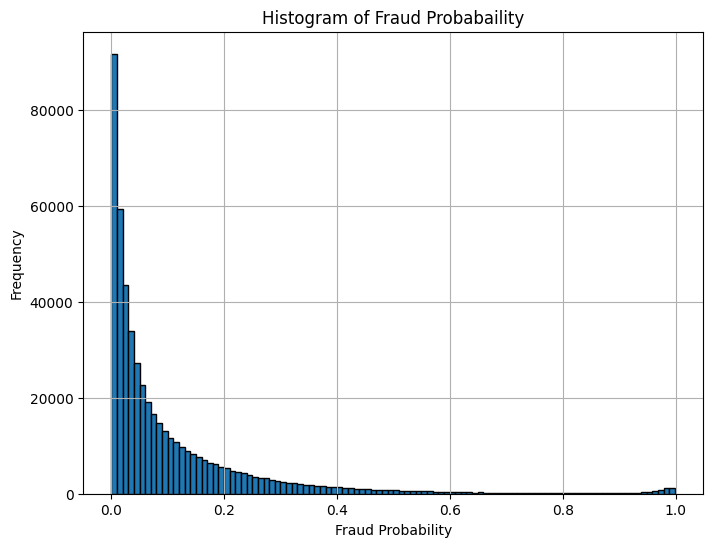

In [25]:
# 3.Apply functions on dataset as needed
# Read .csv's
train_id_df = pd.read_csv(r"ieee-fraud-detection\train_identity.csv")
train_transaction_df = pd.read_csv(r"ieee-fraud-detection\train_transaction.csv")
test_id_df = pd.read_csv(r"ieee-fraud-detection\test_identity.csv")
test_transaction_df = pd.read_csv(r"ieee-fraud-detection\test_transaction.csv")

# Store dfs as a list
dfs_list = [train_id_df, train_transaction_df, test_id_df, test_transaction_df]

# Call preprocessing class
PPD = preprocessDatasets()

# Iterate through list and remove cols with >90% missing values in the df
for df in dfs_list:
  PPD.remove_empty_cols(df)

# Join ID df and transaction df based on transaction ID
train_df = PPD.join_ID(train_transaction_df, train_id_df)
test_df = PPD.join_ID(test_transaction_df, test_id_df)

# Remove outliers (>3sigma) in transaction amount for model to learn from majority data
train_df = PPD.remove_outliers(train_df, 'TransactionAmt')

# Feature engineer train & test sets to maintain consistency
train_df = PPD.feature_engineer(train_df)
test_df = PPD.feature_engineer(test_df)

# Replace blanks
PPD.replace_blanks(train_df)
PPD.replace_blanks(test_df)

# Plot common graphs to understand dataset
VD = visualizeDataset()
VD.plot_hist(train_df, 'TransactionAmt', plot_fraud=True)
VD.plot_fraud_per_period(train_df, ['DayOfWeek', 'HourOfDay'])

# Collect 'C' & 'D' columns for correlation matrix, adjust cols as needed
C_list = []
D_list = [f'D{i_0}' for i_0 in range(1, 7)] + [f'D{i_0}' for i_0 in range(8, 16)]

for col in train_df.columns:
  if col.startswith('C'):
    C_list.append(col)

# View  different column subsets in correlation matrix as needed
VD.plot_correlation(train_df, C_list)
VD.plot_correlation(train_df, D_list)

# Reduce memory occupied by datasets
PPD.reduce_memory(train_df)
PPD.reduce_memory(test_df)

# Encode and scale datasets appropriately
train_df = PPD.encode_df(train_df)
test_df = PPD.encode_df(test_df)

# Call class for dimensionality reduction since V-column count is very high
RD = ReduceDeminesion(train_df, test_df)
train_df, test_df = RD.plot_and_reduceD()
train_df, test_df = PPD.final_preprocessing(train_df, test_df)  # Apply final preprocessing (drop irrelevant cols, etc.)

# Separate features (X) and target (y)
X_train = train_df.drop(columns=['isFraud'])  # Drop the 'isFraud' column to get features
y_train = train_df['isFraud']  # Target column
X_test = test_df  # The test set does not have 'isFraud'

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

AM = applyModel()
xgbModel = AM.trainModel(X_train_split, X_val_split, y_train_split, y_val_split)
final_predictions = AM.pred_and_submit(xgbModel, X_test)